**Curso:** Storytelling para Ciência de Dados e Inteligência Artificial 

**Universidade:** Pontifícia Universidade Católica de São Paulo 

**Ano:** 2024 

**Autores:**

- Fabiana Campanari
- Gabriel Melo
- Pedro Vyctor Carvalho de Almeida
- Luan Augusto dos Santos Fabiano
- Pedro Gallego Barenco
- José Augusto de Souza Oliveira

# Características príncipais para o entendimento do estudo
- **Carat:** É o quilate do diamante.
- **Cut:** É o tipo de corte do diamante.
- **Color:** É a cor do diamante.
- **Clarity:** É a pureza/claridade do diamante.
- **Price:** Preço do diamante.
- **Depth:** É a porcentagem total da profundidade do diamante.
- **Table:** Largura da parte superior do diamante em relação ao ponto mais largo.
- **x:** Comprimento do diamante.
- **y:** Largura do diamante.
- **z:** Profundidade do diamante.

# Introdução

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;O propósito deste projeto é criar um site que defina o preço de um diamante com base em suas características: carat (quilate), cut (corte), color (cor), clarity (claridade), price (preço), depth (profundidade), table (tabela), x (comprimento), y (largura) e z (profundidade). Entretanto, em casos extremos onde é necessário fazer uma estimativa rápida do valor de um diamante, não é viável perder tempo definindo todas essas características. Por isso, é necessário realizar um estudo da base de dados para determinar quais são as características mínimas necessárias para estimar o preço de um diamante de forma precisa.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Para implementar o projeto, é essencial avaliar como cada característica do diamante influencia seu preço. Isso requer descobrir como a variabilidade de uma característica pode afetar a variabilidade do preço. Portanto, o uso de estratégias estatísticas será crucial para responder a essas questões e garantir a precisão das estimativas de valor dos diamantes.

# **Importação das bibliotecas e carregamento do Dataframe**

In [188]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder

In [189]:
#Mudar a path da base de dados 
path = r"DataBases\Diamonds_values_faltantes.csv"
diamonds = pd.read_csv(fr"{path}")

diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,Premium,E,NaN,61.2,61.0,326.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334.0,NaN,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,62.5,57.0,2757.0,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757.0,5.69,5.75,3.61
53937,0.70,NaN,D,SI1,62.8,60.0,2757.0,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757.0,6.15,6.12,3.74


# **Visualização de coeficiênte de correlação linear e separação da base de dados, para melhor implementação do KNN.**

Abaixo está a quantidade de valores faltantes por coluna

In [190]:
counter = {}
for x in range(diamonds.shape[1]):
    column_name = diamonds.columns[x]
    counter[column_name] = diamonds.shape[0] - len(diamonds[column_name].dropna())

counter_df = pd.DataFrame(list(counter.items()), columns=['Coluna', 'Quantidade de NaN'])
counter_df

,Coluna,Quantidade de NaN
0,carat,1649
1,cut,1556
2,color,1540
3,clarity,1476
4,depth,1421
5,table,1369
6,price,1340
7,x,1308
8,y,1253
9,z,1257


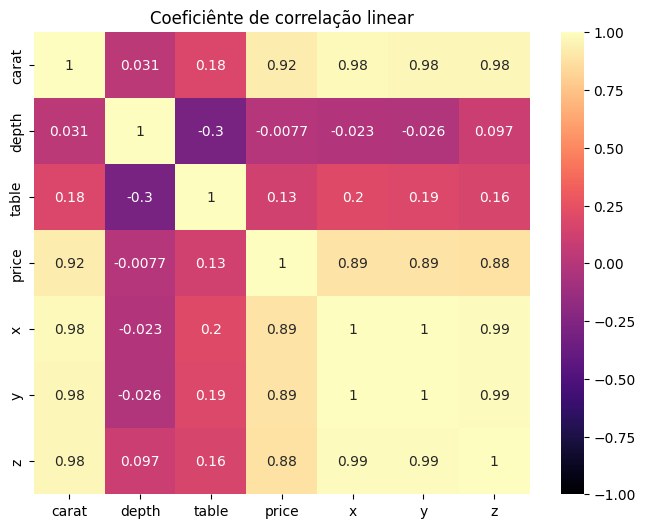

In [191]:
plt.figure(figsize = (8, 6))
sns.heatmap((diamonds[["carat", "depth", "table", "price", "x", "y", "z"]]).corr(), vmin = -1, vmax = 1, annot = True, cmap = 'magma')
plt.title("Coeficiênte de correlação linear")
plt.show()

**Análise do heatmap acima com base no price(preço):**
- Podemos concluir que o price(preço) não tem uma correlação boa com a porcentagem total do diamante(depth) e também não tem uma correlação alta com o table, sendo uma correlação inversamente proporcional de -0,0086 com o depth, e uma relação proporcional de 0,13 com o table.
- Podemos concluir também que o preço tem uma boa correlação linear com o carat(quilate) de 0,92, x(comprimento) de 0,89, y(largura) de 0,89 e z(profundidade) de 0,88.

Com base nessa análise do heatmap, podemos concluir que quanto maior o carat(quilate), x(comprimento), y(largura) e z(profundidade), maior poderá ser o price(preço) do diamante.

Entretato, podem existir alguns casos, de se ter um diamante com um quilate muito alto porém com um preço baixo, assim como poderá existir diamantes com um quilate baixo mas com um preço alto. Tal, poderá também acontecer com o x(comprimento), y(largura) e z(profundidade), por causa disso nos questionamos o seguinte, quanto que o carat(quilate), x(comprimento), y(largura) e z(profundidade) conseguem determinar o valor do diamante? Para responder isso, precisamos tirar o Coeficiênte de Determinação.

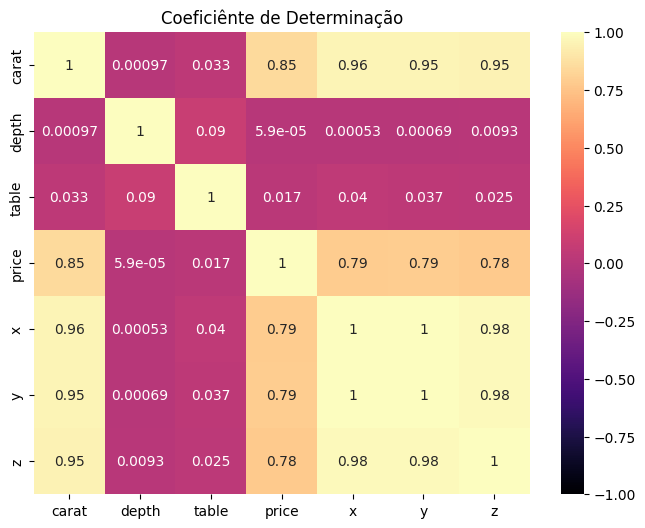

In [192]:
plt.figure(figsize = (8, 6))
sns.heatmap((diamonds[["carat", "depth", "table", "price", "x", "y", "z"]]).corr()**2, vmin = -1, vmax = 1, annot = True, cmap = 'magma')
plt.title("Coeficiênte de Determinação")
plt.show()

**Análise do heatmap acima com base no price(preço):**

Ao analisarmos o heatmap acima, podemos perceber que podemos definir o preço do diamante com maior confiabilidade usando a variável numérica carat(quilate), com confiabilidade de 85%, isso significa que por mais que possamos dizer que quanto maior o quilate do diamante maior o seu preço, infelizmente essa regra só é de fato válida para 85% dos dados.

Já para x(comprimento), y(largura) e z(profundidade), essa confiabilidade é de apenas 79% para comprimento e largura, e 78% para profundidade, o que não é uma determinação forte, e por isso poderão ser desconsideradas caso as variáveis categóricas, consigam definir com precisão o preço do diamante.

Abaixo estamos realizando o processo de separação da base de dados diamonds. Para que assim, o processo de machine learn seja mais efetivo.

- Cut tem 5 tipos de classificação Ideal, Premium, Good, Very Good e Fair

- Color tem 7 tipos de classificação E, I, J, H, F, G e D

- Clarity tem 8 tipos de classificação SI2, SI1, VS1, VS2, VVS2, VVS1, I1 e IF

# **Análise da relação de preço das colunas numéricas**

**INFORMAÇÕES IMPORTANTES:**
- 1 Quilate equivale a 200mg
- 1 Ponto equivale a 0,01 quilates

O gráfico abaixo compara a relação do comprimento de um diamante com o carat e com o preço

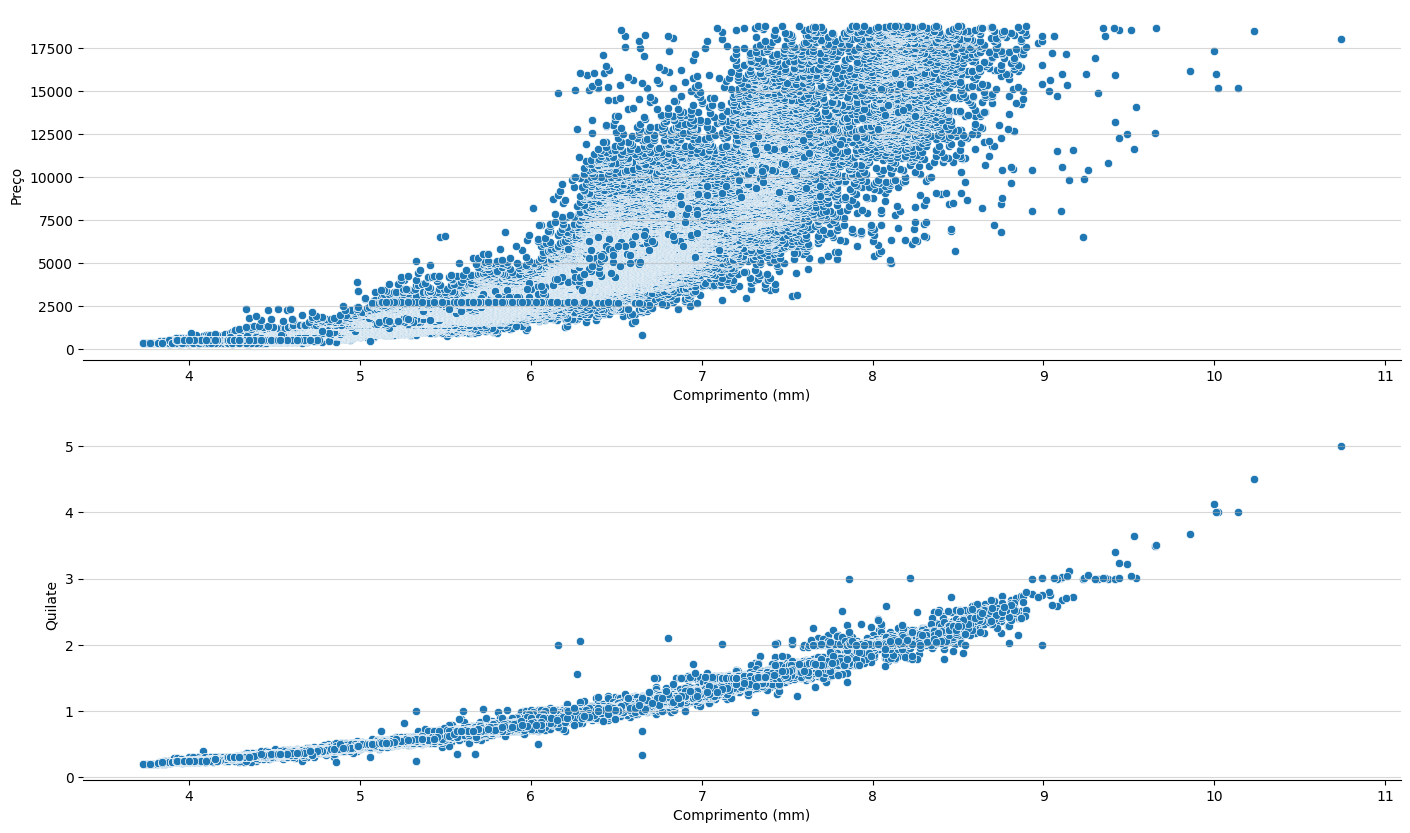

In [193]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 1, 1)
sns.scatterplot(data=diamonds, x =  "x", y = "price")
plt.xlabel("Comprimento (mm)")
plt.ylabel("Preço")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.grid(axis = "y", alpha = 0.5)

plt.subplot(2, 1, 2)
sns.scatterplot(data=diamonds, x = "x", y = "carat")
plt.xlabel("Comprimento (mm)")
plt.ylabel("Quilate")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.grid(axis = "y", alpha = 0.5)

plt.show()

O gráfico abaixo compara a relação da largura de um diamante com o carat e com o preço

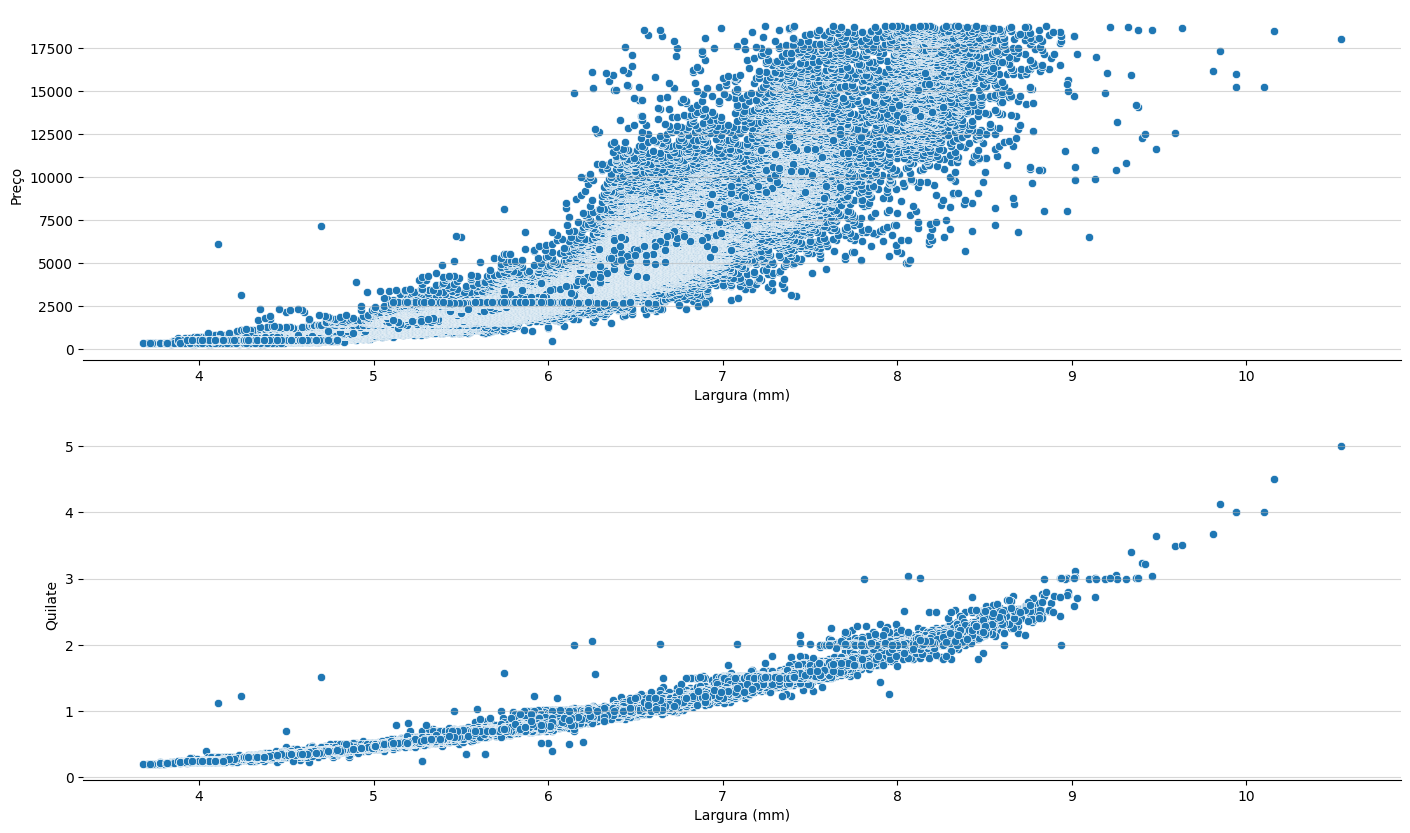

In [194]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 1, 1)
sns.scatterplot(diamonds, x = "y", y = "price")
plt.xlabel("Largura (mm)")
plt.ylabel("Preço")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.grid(axis = "y", alpha = 0.5)

plt.subplot(2, 1, 2)
sns.scatterplot(diamonds, x = "y", y = "carat")

plt.xlabel("Largura (mm)")
plt.ylabel("Quilate")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.grid(axis = "y", alpha = 0.5)

plt.show()

O gráfico abaixo compara a relação da profundidade de um diamante com o carat e com o preço

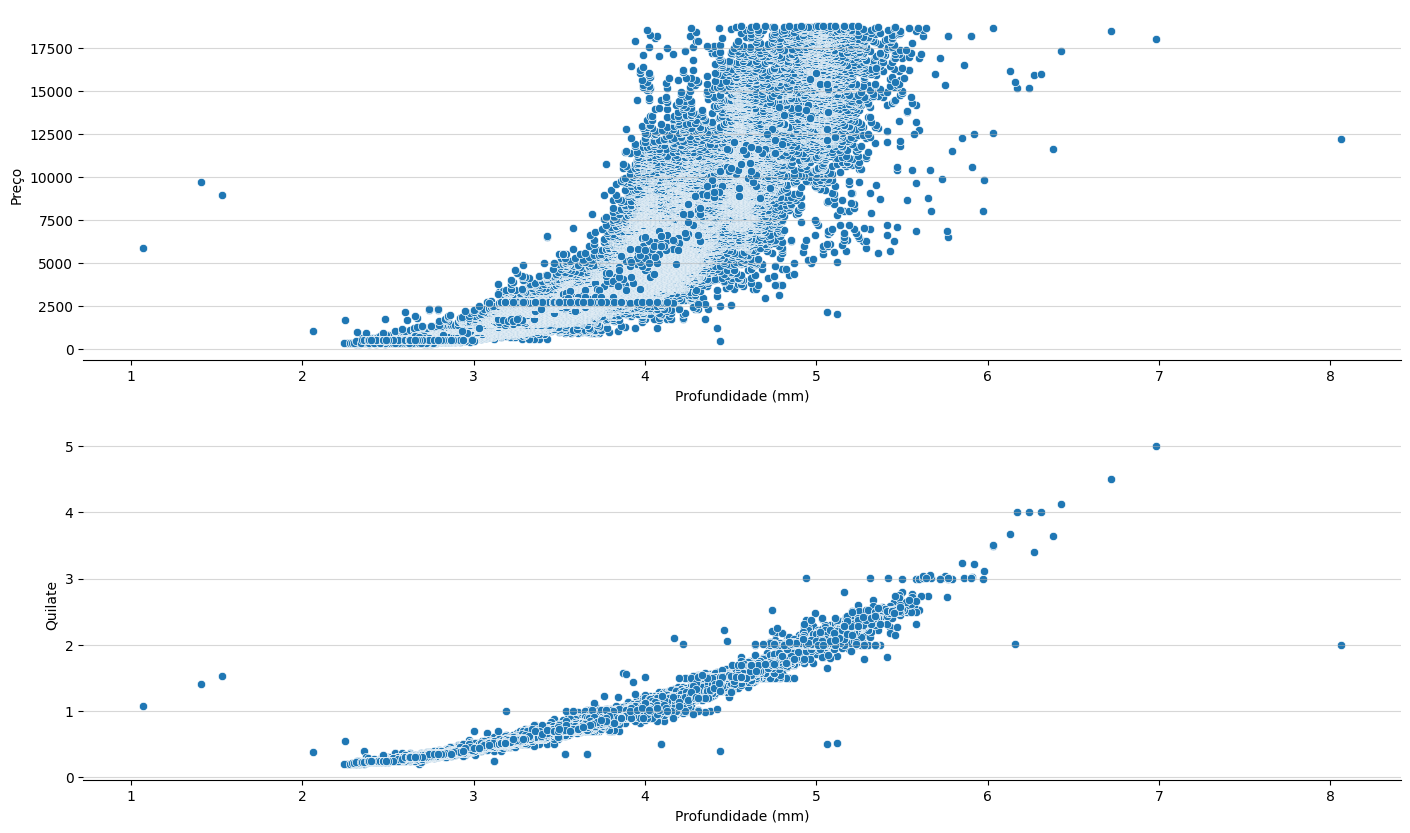

In [195]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 1, 1)
sns.scatterplot(diamonds, x = "z", y = "price")
plt.xlabel("Profundidade (mm)")
plt.ylabel("Preço")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.grid(axis = "y", alpha = 0.5)

plt.subplot(2, 1, 2)
sns.scatterplot(diamonds, x = "z", y = "carat")
plt.xlabel("Profundidade (mm)")
plt.ylabel("Quilate")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.grid(axis = "y", alpha = 0.5)

plt.show()

O gráfico abaixo compara a relação do quilate de um diamante com o preço

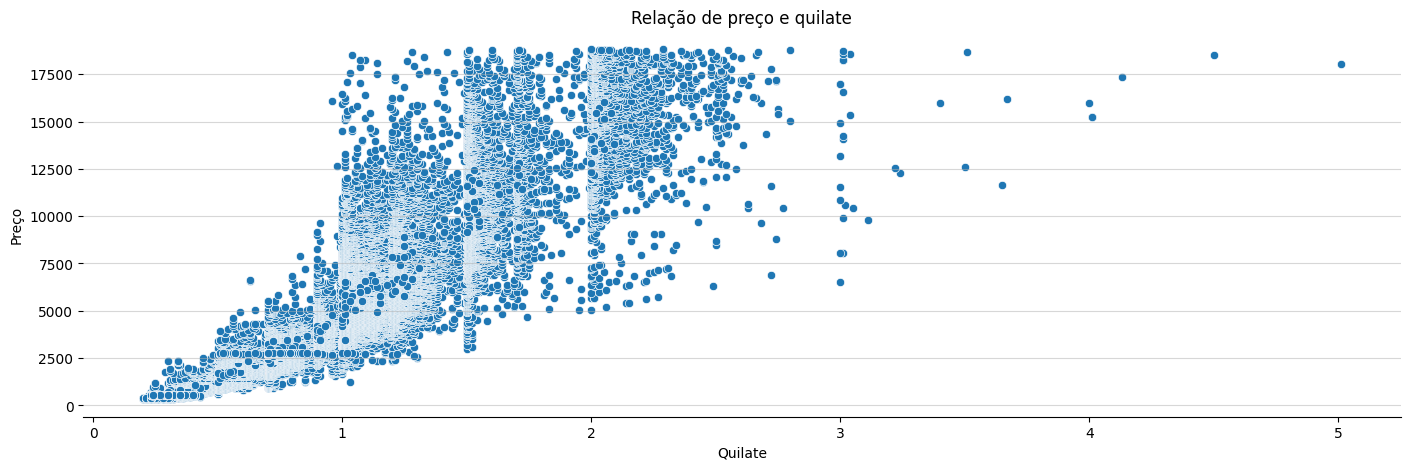

In [196]:
plt.figure(figsize=(17, 5))
sns.scatterplot(diamonds, x = "carat", y = "price")
plt.xlabel("Quilate")
plt.ylabel("Preço")
plt.title("Relação de preço e quilate")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.grid(axis = "y", alpha = 0.5)

plt.show()

Com base nos gráficos apresentados, é evidente que o comprimento, largura e profundidade de um diamante têm uma relação mais confiável com seu peso em quilates do que com seu preço. Portanto, ao determinar o valor de um diamante com o mínimo de medidas necessárias, podemos confiar nos dados de quilates fornecidos. As dimensões físicas, como comprimento, largura e profundidade, oferecem uma indicação mais precisa do peso do diamante do que do seu valor monetário.

Entretanto, é importante ressaltar que isso não significa que não podemos usar as medidas de comprimento, largura e profundidade para estimar o valor de um diamante. Pelo contrário, quanto mais informações tivermos, mais precisa será a estimativa do preço do diamante. No entanto, se tivermos que escolher o mínimo de informações para estimar o valor de um diamante, podemos afirmar que o quilate é suficiente para essa avaliação.

#### **Existem 3 formar de estimar o preço do diamante para o usuário do programa:**
1) Solicitar a massa do diamante para o cliente, e com isso realizar o cálculo:   
$$ \text{Quilate} = \frac{\text{Massa (mg)}}{200}$$

2) Quando o usuário fornece os pontos do diamante:
$$Quilate = \frac{\text{Pontos (pt)}}{100}$$

3) Para a segunda forma de estimar o quilate do diamante, é necessário 4 coisas: Comprimento (mm), Largura (mm), Profundidade (mm) e densidade ($\frac{mm}{mm³}$). Com isso utilizaremos o cálculo da densidade de um objeto, para assim cálcular primeiramante a massa do diamante: $$Densidade = \frac{Massa}{Volume} \rightarrow Massa = Densidade \times Volume $$ Entretanto temos um problema, não temos o volume do diamante, entretanto para isso, iremos dismenbrar o cálculo do volume de um objeto, sendo: $$Volume = Comprimento \times Largura \times Profundidade$$ Substituindo na fórmula então, ficará: $$Massa = Comprimento \times Largura \times Profundidade \times Densidade$$ Agora teremos de descobrir o quilate do diamante, para isso, usaremos a forma 1 de estimar o cálculo do diamante: $$Quilate = \frac{Massa (mg)}{200}$$ Ficando na fórmula geral: $$Quilate = \frac{Densidade \times Volume}{200}$$ $$\text{OU}$$  $$Quilate = \frac{Comprimento \times Largura \times Profundidade \times Densidade}{200} $$

# **Relação de preço com as colunas categóricas**

In [197]:
diamonds.describe()

,carat,depth,table,price,x,y,z
count,52291.000000,52519.000000,52571.000000,52600.000000,52632.000000,52687.000000,52683.000000
mean,0.797165,61.751785,57.456278,3931.501369,5.730423,5.733263,3.539827
std,0.472946,1.416642,2.219358,3982.202061,1.117590,1.110212,0.690975
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000
25%,0.400000,61.100000,56.000000,951.750000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2405.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5340.250000,6.540000,6.540000,4.030000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,10.540000,8.060000


In [198]:
description = diamonds.describe()
price = [f"until ${description.iloc[4, 3]}", 
    f"until ${description.iloc[5, 3]}",
    f"until ${description.iloc[6, 3]}",
    f"greater than ${description.iloc[6, 3]}"]

carat = [f"until ${description.iloc[4, 0]}", 
    f"until ${description.iloc[5, 0]}",
    f"until ${description.iloc[6, 0]}",
    f"greater than ${description.iloc[6, 0]}"]

    
def agrupamento(diamonds, coluna, index_coluna: list):
    if coluna == "price":
        coluna_aux = 3
    else:
        coluna_aux = 0

    description = diamonds.describe()
    cut = pd.DataFrame({"Fair": [0.0 for x in range(4)],
                        "Good": [0.0 for x in range(4)],
                        "Very Good": [0.0 for x in range(4)],
                        "Premium": [0.0 for x in range(4)],
                        "Ideal": [0.0 for x in range(4)]}, 
                        index = index_coluna)

    color = pd.DataFrame({"J": [0.0 for x in range(4)],
                        "D": [0.0 for x in range(4)],
                        "I": [0.0 for x in range(4)],
                        "E": [0.0 for x in range(4)],
                        "F": [0.0 for x in range(4)],
                        "H": [0.0 for x in range(4)],
                        "G": [0.0 for x in range(4)]}, 
                        index = index_coluna)

    clarity = pd.DataFrame({"I1": [0.0 for x in range(4)],
                            "IF": [0.0 for x in range(4)],
                            "VVS1": [0.0 for x in range(4)],
                            "VVS2": [0.0 for x in range(4)],
                            "VS1": [0.0 for x in range(4)],
                            "VS2": [0.0 for x in range(4)],
                            "SI2": [0.0 for x in range(4)],
                            "SI1": [0.0 for x in range(4)]}, 
                            index = index_coluna)

    for intervalo in ["25%", "50%", "75%", "max"]:
        if intervalo == "25%":
            diamonds_aux = diamonds[diamonds[coluna] <= diamonds.describe()[coluna][intervalo]].reset_index()
            
        elif intervalo == "50%":
            diamonds_aux = diamonds[diamonds[coluna] > diamonds.describe()[coluna]["25%"]].reset_index()
            diamonds_aux = diamonds_aux[diamonds_aux[coluna] <= diamonds.describe()[coluna][intervalo]].reset_index()
            
        elif intervalo == "75%":
            diamonds_aux = diamonds[diamonds[coluna] > diamonds.describe()[coluna]["50%"]].reset_index()
            diamonds_aux = diamonds_aux[diamonds_aux[coluna] <= diamonds.describe()[coluna][intervalo]].reset_index()
            
        else:
            diamonds_aux = diamonds[diamonds[coluna] > diamonds.describe()[coluna]["75%"]].reset_index()
        
        describe = diamonds.describe()[coluna][intervalo]
        
        for x in range(diamonds_aux.shape[0]):
            for y in range(cut.shape[1]):
                if diamonds_aux.loc[x, "cut"] == cut.columns[y]:
                    try:
                        cut.loc[f"until ${describe}", cut.columns[y]] += 1.0
                    except KeyError:
                        cut.loc[f"greater than ${description.iloc[6, coluna_aux]}", cut.columns[y]] += 1.0
                    break
                
            for y in range(color.shape[1]):
                if diamonds_aux.loc[x, "color"] == color.columns[y]:
                    try:
                        color.loc[f"until ${describe}", color.columns[y]] += 1.0
                    except KeyError:
                        color.loc[f"greater than ${description.iloc[6, coluna_aux]}", color.columns[y]] += 1.0
                    break
                
            for y in range(clarity.shape[1]):
                if diamonds_aux.loc[x, "clarity"] == clarity.columns[y]:
                    try:
                        clarity.loc[f"until ${describe}", clarity.columns[y]] += 1.0
                    except (KeyError, KeyboardInterrupt):
                        clarity.loc[f"greater than ${description.iloc[6, coluna_aux]}", clarity.columns[y]] += 1.0
                    break

    soma_cut = [sum(cut.iloc[:, x]) for x in range(cut.shape[1])]
    soma_color = [sum(color.iloc[:, x]) for x in range(color.shape[1])]
    soma_clarity = [sum(clarity.iloc[:, x]) for x in range(clarity.shape[1])]

    for x in range(4):
        for y in range(cut.shape[1]):
            cut.iloc[x, y] = round(cut.iloc[x, y] / soma_cut[y], 4).astype(float)
        for y in range(color.shape[1]):
            color.iloc[x, y] = round(color.iloc[x, y] / soma_color[y], 4).astype(float)
        for y in range(clarity.shape[1]):
            clarity.iloc[x, y] = round(clarity.iloc[x, y] / soma_clarity[y], 4).astype(float)

    if "carat" == coluna:
        cut.index = [f"until {description.iloc[4, 0]}", 
                    f"until {description.iloc[5, 0]}",
                    f"until {description.iloc[6, 0]}",
                    f"greater than {description.iloc[6, 0]}"]
        
        color.index = [f"until {description.iloc[4, 0]}", 
                    f"until {description.iloc[5, 0]}",
                    f"until {description.iloc[6, 0]}",
                    f"greater than {description.iloc[6, 0]}"]
        
        clarity.index = [f"until {description.iloc[4, 0]}", 
                    f"until {description.iloc[5, 0]}",
                    f"until {description.iloc[6, 0]}",
                    f"greater than {description.iloc[6, 0]}"]
        

    return cut, color, clarity

In [199]:
cut, color, clarity = agrupamento(diamonds, "price", price)
cut_carat, color_carat, clarity_carat = agrupamento(diamonds, "carat", carat)

O comando acima cria seis tabelas que exibem, em porcentagens, a quantidade de diamantes com determinadas características dentro de intervalos de valores específicos. Além disso, são geradas outras três tabelas semelhantes, mas, em vez de agrupar os dados pelo preço, eles são agrupados pelo peso em quilates (carat).

In [200]:
cut

,Fair,Good,Very Good,Premium,Ideal
until $951.75,0.0551,0.2165,0.2571,0.2135,0.2909
until $2405.0,0.2873,0.2205,0.2110,0.2201,0.2936
until $5340.25,0.4167,0.3342,0.2795,0.2533,0.2014
greater than $5340.25,0.2409,0.2288,0.2523,0.3131,0.2141


In [201]:
cut_carat

,Fair,Good,Very Good,Premium,Ideal
until 0.4,0.0414,0.1925,0.2453,0.2354,0.3333
until 0.7,0.2172,0.2367,0.2255,0.1896,0.2717
until 1.04,0.4525,0.3606,0.2960,0.2486,0.1843
greater than 1.04,0.2888,0.2102,0.2332,0.3264,0.2107


Ao analisarmos os gráficos acima, podemos identificar quais cortes tendem a ter maiores pesos em quilates e preços, e quais cortes tendem a ter menores pesos em quilates e preços. Observamos que o corte influencia mais o peso em quilates do que o preço. No entanto, o corte pode nos auxiliar na determinação do intervalo de valores em que o diamante se enquadra. Uma vez definido o quilate, torna-se mais claro determinar um intervalo de preços para o diamante, permitindo assim uma estimativa mais precisa do seu valor.

In [202]:
color

,J,D,I,E,F,H,G
until $951.75,0.1546,0.2784,0.2157,0.2832,0.2414,0.2401,0.2576
until $2405.0,0.1870,0.3019,0.1635,0.3081,0.2769,0.1727,0.2596
until $5340.25,0.2756,0.2523,0.2684,0.2517,0.2596,0.2789,0.2011
greater than $5340.25,0.3828,0.1675,0.3524,0.1570,0.2221,0.3083,0.2817


In [203]:
color_carat

,J,D,I,E,F,H,G
until 0.4,0.1174,0.3190,0.1950,0.3317,0.2648,0.2371,0.2771
until 0.7,0.1271,0.3042,0.1411,0.2945,0.2698,0.1598,0.2417
until 1.04,0.2167,0.2555,0.2215,0.2540,0.2868,0.2378,0.2335
greater than 1.04,0.5388,0.1213,0.4424,0.1198,0.1785,0.3653,0.2476


Diferentemente dos gráficos de corte (cut), podemos notar uma separação mais clara nos intervalos de valores ao analisar as cores dos diamantes. Isso nos permite observar com maior precisão quais cores têm uma tendência maior de apresentar quilates elevados e quais tendem a ter quilates mais baixos. Também conseguimos identificar quais cores de diamantes estão associadas a preços mais altos e quais tendem a ter valores mais baixos. Assim como o corte, a cor pode ser utilizada para estimar o preço do diamante, pois oferece uma indicação mais clara das tendências de preço e quilate.

In [204]:
clarity

,I1,IF,VVS1,VVS2,VS1,VS2,SI2,SI1
until $951.75,0.0728,0.3475,0.3781,0.3526,0.2826,0.2778,0.1134,0.2212
until $2405.0,0.2518,0.4104,0.3775,0.3006,0.2688,0.2542,0.1658,0.2196
until $5340.25,0.4323,0.0941,0.1216,0.1314,0.1768,0.1791,0.4400,0.3167
greater than $5340.25,0.2431,0.1480,0.1228,0.2154,0.2718,0.2890,0.2807,0.2426


In [205]:
clarity_carat

,I1,IF,VVS1,VVS2,VS1,VS2,SI2,SI1
until 0.4,0.0233,0.6046,0.5518,0.4311,0.3023,0.2906,0.0840,0.1821
until 0.7,0.1179,0.2104,0.2650,0.2795,0.2720,0.2541,0.1484,0.2420
until 1.04,0.3013,0.0892,0.1004,0.1485,0.2113,0.2268,0.3560,0.3153
greater than 1.04,0.5575,0.0958,0.0827,0.1408,0.2144,0.2285,0.4116,0.2605


Assim como vimos em cut(corte) e color(cor), a clarity(claridade) também é uma boa característica para poder descobrir o price(preço) do diamante, já que assim como as outras características, a mesma tem uma precisão maior ao definir um valor para carat(quilate) do que para o preço do diamante. Também conseguimos identificar quais claridades do diamantes estão associadas a preços mais altos e quais tendem a ter valores mais baixos. Assim como o corte, a cor pode ser utilizada para estimar o preço do diamante, pois oferece uma indicação mais clara das tendências de preço e quilate.

Contudo, podemos afirmar que as colunas categóricas da base de dados são essenciais para estimar o valor do diamante. Elas fornecem informações cruciais que permitem uma estimativa do preço da joia, auxiliando na determinação do valor do diamante. Portanto, essas colunas devem ser consideradas variáveis obrigatórias para o usuário ao realizar essa análise.

# **Implementação do K-NN (K-Nearest Neighbors)**

Colocando medições iguais a 0 de comprimento, largura e/ou profundidade de um diamante como NaN

In [206]:
for x in range(diamonds.shape[0]):
    for y in range(7, diamonds.shape[1]):
        if diamonds.iloc[x, y] == 0: diamonds.iloc[x, y] = np.nan
        elif diamonds.iloc[x, y] >= 30: diamonds.iloc[x, y] = np.nan
diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,Premium,E,NaN,61.2,61.0,326.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334.0,NaN,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,62.5,57.0,2757.0,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757.0,5.69,5.75,3.61
53937,0.70,NaN,D,SI1,62.8,60.0,2757.0,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757.0,6.15,6.12,3.74


Para realizar o cálculo da distância do diamante, na qual queremos descobrir o preço, usaremos o cálculo da distância euclidiana:
$$d(A,B)= \sqrt{\sum_{i=1}^{n} (A_i - B_i)^2}$$

- A é o eixo do ponto que queremos prever o valor.
- B é o eixo de um ponto já definido.

In [207]:
'''KNN para valores categóricos'''
encoder = OrdinalEncoder()
diamonds_encoder = encoder.fit_transform(diamonds)

knn_imputer = KNNImputer(n_neighbors = round(math.log(diamonds.shape[0])), metric = "nan_euclidean")
test = knn_imputer.fit_transform(diamonds_encoder)


diamonds_imputer = pd.DataFrame(test, columns = diamonds.columns)
diamonds_imputer = encoder.inverse_transform(diamonds_imputer)
diamonds = pd.DataFrame(diamonds_imputer, columns = diamonds.columns)

diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,Premium,E,VS1,61.2,61.0,326.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334.0,4.22,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,62.5,57.0,2757.0,5.75,5.76,3.5
53936,0.72,Good,D,SI1,63.1,55.0,2757.0,5.69,5.75,3.61
53937,0.7,Ideal,D,SI1,62.8,60.0,2757.0,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757.0,6.15,6.12,3.74


Salvando a base de dados já limpa e sem valores faltantes

In [208]:
path = r"DataBases\Diamonds_limpa.csv"
try:
    pd.read_csv(f"{path}")
    print(f"Já existe esse dataframe no diretório: {path}")
except FileNotFoundError:
    diamonds.to_csv(fr"{path}", index = False)
    print(f'''Base de dados limpa adicionada ao diretório:
          {path}
          com sucesso!!''')


Já existe esse dataframe no diretório: DataBases\Diamonds_limpa.csv


Por fim, tentamos salvar a base de dados sem nenhum valor faltante ou incorreto na pasta "Databases". Se conseguirmos, isso indica que a base de dados não estava previamente salva. Caso contrário, a base de dados já estava salva.

Por fim, já podemos pegar a base de dados limpa, e usa-la para prever os valores dos diamantes.